# Bias correction with a random forest

**Authors**: [Matthew Chantry](https://www.ecmwf.int/en/about/who-we-are/staff-profiles/matthew-chantry) and [Fenwick Cooper](https://www.physics.ox.ac.uk/our-people/cooperf)

*This notebook was last tested and operational on 30/09/2025. Please [report any issues](https://github.com/ecmwf-training/ml-examples/issues).*

:::{admonition} About
:class: note, dropdown
This notebook was originally created for ECMWF's [MOOC on Machine Learning in Weather and Climate](https://learning.ecmwf.int/course/index.php?categoryid=1), and has been lightly updated and tested for the purposes of this collection of examples. The original notebook can be found [here](https://github.com/ecmwf-training/mooc-machine-learning-weather-climate/blob/main/tier_2/regression_decision_trees/random_forest.ipynb).

This example of using machine learning to model weather forecast error based on work by Fenwick Cooper funded by <a href="https://www.ifabfoundation.org/">IFAB</a>, the full study can be found <a href="https://www.ecmwf.int/en/elibrary/81297-statistical-modelling-2m-temperature-and-10m-wind-speed-forecast-errors">here</a>.
:::

:::{admonition} Running this notebook
:class: tip, dropdown
This notebook can be run/accessed on the following free online platforms. Please note they are not officially supported by or linked with ECMWF. See [Running the notebooks](sec:running_notebooks) for more details.

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/ml-examples/blob/develop/ex_Random_Forest_Postprocessing.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/ml-examples/blob/develop/ex_Random_Forest_Postprocessing.ipynb)
[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/ml-examples/develop?labpath=ex_Random_Forest_Postprocessing.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/ml-examples/blob/develop/ex_Random_Forest_Postprocessing.ipynb)

:::

## Introduction

In this example we will apply a random forest model to the ECMWF forecast of surface temperature. Specifically, we are trying to predict the difference between station observations of 2m-temperature and the corresponding forecast prediction at the nearest gridpoint to the observation location. If we can accurately predict this difference (the forecast error) we can compensate for it, making the forecast more accurate. This type of approach is called *bias correction*, which is a form of statistical post-processing.

### Random forests

Before getting into the example, let's do a quick refresher on random forests. Consider a decision tree, which behaves much like a flow chart. Decision trees partition our input data through a series of binary decisions, one variable at a time. Partitions are made, for example, by splitting on temperature >= 0 or temperature < 0. Each of these decisions creates two branches.

For each branch, there is another decision to further split the data, until some stopping criteria is met. For example, when a branch contains a minimum number of data points, or the number of decisions in the tree meets some threshold. These decisions are automatically designed to optimally partition the data.

During prediction, your input data is sorted into the partitions (nodes) created by the decision tree. For a *regression* decision tree, the output is then the value (or average of values) of the subset of the training data which belongs to this node.

A random forest is a collection of decision trees, purposely designed to differ from one another, where the final answer is the average of the prediction from all the decision trees. Random forests tend to correct the overfitting which occurs on single decision trees, and are a powerful tool, particularly for learning "tabular" data.

We will see below how this threshold-based approach creates a "blocky" prediction space, but one that performs well on many error metrics. For more info on random forests in the context of weather and climate, see Tier 2 of our [ML MOOC](https://learning.ecmwf.int/course/index.php?categoryid=1).

### In this notebook

We will explore several physically-motivated predictors. The choice of which powers or combinations of features to use could be informed by our physical understanding of the problem.

The steps we will follow are:

## Prepare your environment

The following packages are used to process and model the data:

- numpy for handling arrays and mathematical functions
- sklearn for machine learning tools
- matplotlib for plots

In [1]:
# First import the tools we will use. Where possible it is always worth using
# existing tools, even if the mathematics are simple to write down yourself.
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

Before going further, we also have to download a utility function for plotting. This is contained within a [plugin](https://github.com/mchantry/climetlab-mltc-surface-observation-postprocessing) to the [Climetlab](https://climetlab.readthedocs.io/en/latest/) package, which is no longer updated. In order to avoid a dependency on this package (which can cause errors in some environments), we load the function directly from the GitHub source code.

In [2]:
# Download the raw Python file from GitHub
!wget -O utils.py https://raw.githubusercontent.com/mchantry/climetlab-mltc-surface-observation-postprocessing/master/climetlab_mltc_surface_observation_postprocessing/utils.py

# Run it in the notebook so functions are available
%run utils.py


--2025-10-01 13:22:00--  https://raw.githubusercontent.com/mchantry/climetlab-mltc-surface-observation-postprocessing/master/climetlab_mltc_surface_observation_postprocessing/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2451 (2.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.39K  --.-KB/s    in 0s      

2025-10-01 13:22:00 (36.9 MB/s) - ‘utils.py’ saved [2451/2451]



## Load data

We will now download the dataset: this comprises 36-hour forecast errors of 2m-temperature from a ECMWF's high resolution forecast system, using station observations as the truth. Currently there are three variables in the dataset:

- `forecast_error`: the difference between the forecasted value of 2m-temperature and the observed value, in °C.
- `time_of_day`: the local time of day, in decimal hours. Useful for diagnosing the diurnal cycle model bias.
- `soil_temperature`: the model soil temperature, in °C.

For each variable, the dataset contains over 5 million datapoints covering around 8000 weather stations around the world (not specified in the dataset).

We will load each variable separately. Notice that we reshape the explanator variables (features) to 2D arrays (albeit with a single column) for compatability with scikit-learn. The target variable remains a 1D vector.

In [3]:
base_url = "https://object-store.os-api.cci1.ecmwf.int/sop/"

# load in variables one at a time (.reshape() puts in correct format for later)
forecast_error = np.genfromtxt(base_url + "forecast_error.csv", delimiter=",", skip_header=1)
soil_temperature = np.genfromtxt(base_url + "soil_temperature.csv", delimiter=",", skip_header=1).reshape(-1, 1)
time_of_day = np.genfromtxt(base_url + "time_of_day.csv", delimiter=",", skip_header=1).reshape(-1, 1)

Note that an important step of data preprocessing has already been carried out in the curation of the dataset. Spurious data has already been removed from the dataset based upon a range of categories, e.g. stations with inconsistent measurement locations, repeated values, or even physically  invalid numbers (>100°C). If you are starting on a new project this is a key step to clean the data.

## Prepare data

Now we can prepare the data for our model. This involves randomly splitting the data into training and testing sets, such that 80% of the data is in the training set and 20% in the testing set.

Ideally, we would like to know the geospatial location and time of our data points, because this would allow us to design our training/test sets to ensure independence (for more info, see our [ML MOOC](https://learning.ecmwf.int/course/index.php?categoryid=1)). However, we don't have this information, so random sampling will be used. We will also not create a validation set because we are not exploring a hyperparameter space.

The splitting into training and test sets can be done one in one call to the `train_test_split()` function of scikit-learn.

In [4]:
# Split each of the predictands and predictors in a random train/test split.
# We use 80% of the data for training & 20% for testing
(forecast_error_train, forecast_error_test,
    time_of_day_train, time_of_day_test,
    soil_temperature_train,  soil_temperature_test) = train_test_split(forecast_error, #the variables to split
                                                                       time_of_day,
                                                                       soil_temperature,
                                                                       test_size = 0.2, #what proportion of the data to use in the test set
                                                                       random_state = 42, #set the random seed for reproducibility
                                                                      )

## Build model

Next, we train our random forest model. We begin by performing a univariate regression of the forecast error only on the time of day. In the following code, we create the `RandomForestRegressor` model object and define some hyperparameters: the number of trees in the random forest, and the maximum depth of any single tree. We then fit this model to the training data.

This can take a minute or two, so maybe time to get a coffee or a snack.

In [5]:
%%time
# The line above will time how long it takes to excute this block

# Label the input & output data, Random Forest likes a 1D vector to predict.
X = time_of_day_train
Y = forecast_error_train

# Create the Random Forest regression object
# we limit the complexity of the model by selecting a maximum depth of the trees
# you could explore how this change affects the results.
reg = RandomForestRegressor(n_estimators = 10, # The number of trees in the forest
                            max_depth = 10, # the maximum depth any tree is allowed to have
                            )

# Train the model using the data
reg.fit(X, Y)

CPU times: user 43.2 s, sys: 454 ms, total: 43.6 s
Wall time: 43.9 s


RandomForestRegressor(max_depth=10, n_estimators=10)

The model is now fitted. We will evaluate our model using root-mean-squared error (RMSE) and mean-absolute error (MAE). However we want to begin by calculating the RMSE and MAE of the existing forecasts. To do this, we compare the forecast errors with a vector of zeroes (zero being no error). The idea will be to see whether our model can improve on these scores.

In [6]:
# Our baseline is no error correction, or a correction of 0.
zero_test = 0.0*forecast_error_test

#Calculate the MAE
baseline_mae = metrics.mean_absolute_error(zero_test, forecast_error_test)
#Calculate the RMSE
baseline_rmse = np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test))
print('Mean Absolute Error Uncorrected:', baseline_mae)
print('Root Mean Squared Error Uncorrected:', baseline_rmse)

Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456


Can our random forest model improve this? To find out, we will generate error predictions at the times of day used in the test data, and compare with the corresponding observed errors, obtaining new RMSE and MAE values. If these MAE and RMSE are less than the baseline values, this implies that the random forest model would be able to improve the forecasts (by subtracting the resulting errors).

In [7]:
#Build our input array for the test data, then make a prediction with our model
X_test = time_of_day_test # Reshape X to be a 2D array

forecast_corrected = reg.predict(X_test)

corrected_mae = metrics.mean_absolute_error(forecast_error_test, forecast_corrected)
corrected_rmse = np.sqrt(metrics.mean_squared_error(forecast_error_test, forecast_corrected))

print('Mean Absolute Error Corrected:', corrected_mae)
print('Root Mean Squared Error Corrected:', corrected_rmse)

print('% Improvement MAE over raw forecast', -(corrected_mae - baseline_mae)/baseline_mae * 100 )
print('% Improvement RMSE over raw forecast', -(corrected_rmse - baseline_rmse)/baseline_rmse * 100 )


Mean Absolute Error Corrected: 1.5550040575497233
Root Mean Squared Error Corrected: 2.1649836377344442
% Improvement MAE over raw forecast 4.7398126189488226
% Improvement RMSE over raw forecast 4.040166301357749


This shows that we would get an improvement of around 4% if we were to use the random forest model based on time of day to correct the forecast bias.

Now we plot the model error predictions and the observed predictions from the test set against time of day. Because the number of observations is quite large (about one million), we will not plot the observed predictions as individual points, but instead generate a density map using the `imgBufferFromVectors()` function. We'll then overlay our fitted line.

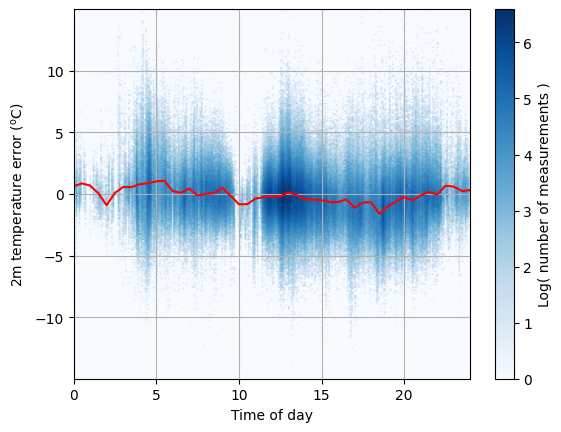

In [8]:
# Predict the outputs for all values between 0 & 24.
x = np.linspace(0, 24, 49)[...,np.newaxis]
y = reg.predict(x)

# Make a graph of the time of day against the forecast error.
# This function helps us build an image of the results
tod_buffer, ax_extent, count = imgBufferFromVectors(time_of_day_test, forecast_error_test.reshape(-1, 1),
                                                    nx=256, ny=256, extent=[],
                                                    calc_average=False)
# Plot the number of measurements at each time of day and forecast error
plt.imshow(np.log((count==0.0)+count),
           cmap='Blues', origin='lower',
           extent=ax_extent, aspect='auto')

plt.xlim([0, 24])
plt.grid()
plt.xlabel('Time of day')
plt.ylabel(r'2m temperature error ($^\mathrm{o}$C)')
cb = plt.colorbar()
cb.set_label('Log( number of measurements )')

# Line of best fit
plt.plot(x,y,'red')

plt.show()

Although the model (red line) is better than nothing (and does indeed have the potential to improve our forecasts slightly), there is still a lot of of variation which is *not* explained. Indeed, the error only seems to have a weak relationship with respect to the time of day.

Does this look like a sensible model? We see a much more complex relationship between time and error than the linear regression model. Should we expect very rapid variation of error with time of day?

We could use a neural network or other machine learning methods to find the red line instead, but no model can account for all of the 2m temperature error with only this single predictor.

How can we improve the results? Let's test whether another predictor can help. We will try using the soil temperature.

## Adding more predictors

Next we will add a second predictor, the model soil temperature. Let's look at how the forecast error varies with these predictors to understand how well we might expect our model to perform.

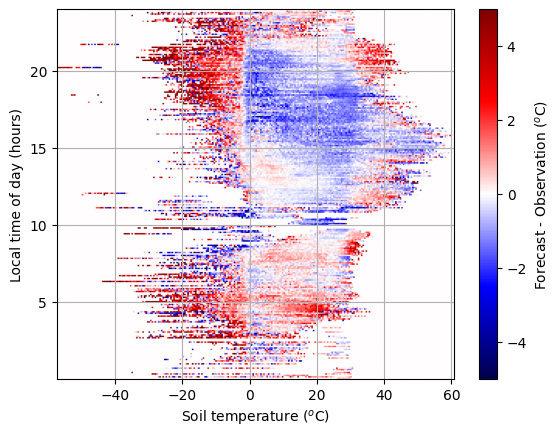

In [9]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(soil_temperature_test,
                                                time_of_day_test,
                                                forecast_error_test.reshape(-1, 1),
                                                256, 256,
                                                extent = [],
                                                calc_average=True)
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

This plot is a heatmap of the forecast error (represented by the colour bar), plotted against the soil temperature and time of day (x and y axes, respectively). We see that forecast errors vary with both of these predictors, so we can expect our model to improve if we add soil temperature as a predictor. It also appears that there is a more discernable pattern in the forecast error, and this implies that it might more be more feasible to model it.

Unlike linear regression, random forests are very good at drawing sharp boundaries in the data, so we will not use the additional frozen soil predictor as used in the linear regression notebook.

We'll now re-train the model with these two predictors. Again, this may take a minute or two to complete.

In [10]:
%%time
# Concatenate predictors into a single array
X = np.concatenate([time_of_day_train, soil_temperature_train],axis=-1)

# Create random forest model
reg = RandomForestRegressor(n_estimators = 10, # The number of trees in the forest
                            max_depth = 10, # the maximum depth any tree is allowed to have
                            )
# Train the model using the train sets
reg.fit(X, Y)

CPU times: user 1min, sys: 365 ms, total: 1min 1s
Wall time: 1min 1s


RandomForestRegressor(max_depth=10, n_estimators=10)

We want to evaluate the performance of our new model. To do so, we follow the same procedure as previously: we generate predictions at the points in the test dataset, and compare the error of the random forest model with the error with respect to the zero baseline.

In [12]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

X_test = np.concatenate([time_of_day_test, soil_temperature_test
              ],axis=-1)

forecast_corrected = reg.predict(X_test)

##forecast_corrected = linear_model.predict(X_apply)
corrected_mae = metrics.mean_absolute_error(forecast_error_test, forecast_corrected)
corrected_rmse = np.sqrt(metrics.mean_squared_error(forecast_error_test, forecast_corrected))

print('Mean Absolute Error Corrected:', corrected_mae)
print('Root Mean Squared Error Corrected:', corrected_rmse)

print('% Improvement MAE over raw forecast', -(corrected_mae - baseline_mae)/baseline_mae * 100 )
print('% Improvement RMSE over raw forecast', -(corrected_rmse - baseline_rmse)/baseline_rmse * 100 )



Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.5286048695102463
Root Mean Squared Error Corrected: 2.119582575240044
% Improvement MAE over raw forecast 6.357037723371269
% Improvement RMSE over raw forecast 6.052504099560873


We see an improvement of ~6% just from using these two predictors. We'll also visualise the results - to do so we have to generate a grid of points over the domain and generate model predictions at those points.

In [13]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0],ax_extent[1],nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2],ax_extent[3],ny)  # Represents time_of_day
x_mesh = np.meshgrid(y_tod,x_st,indexing='ij')
x_mesh = np.stack(x_mesh,axis=-1).reshape((-1,2)) # Combine these predictors together to make the input array.

model_buffer = reg.predict(x_mesh).reshape(buffer.shape) #We need to reshape the output for plotting

We now generate the plots. We'll plot:

1. The observed forecast errors (as plotted previously).
2. The model-predicted forecast errors, at the points in the test set.
3. The model-predicted forecast errors over the whole domain.

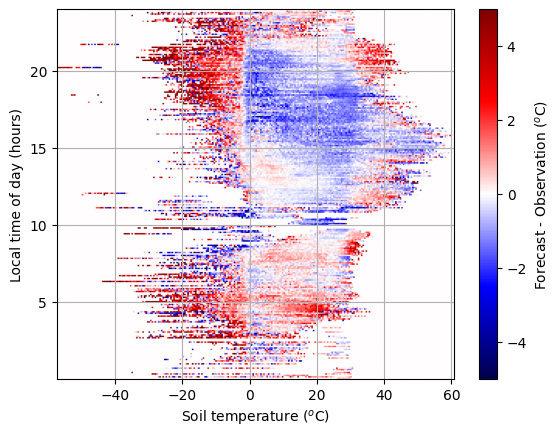

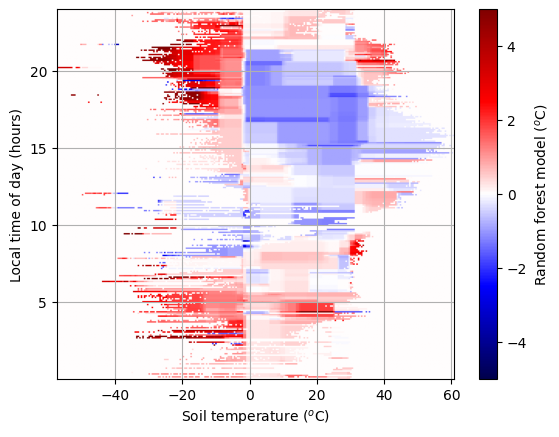

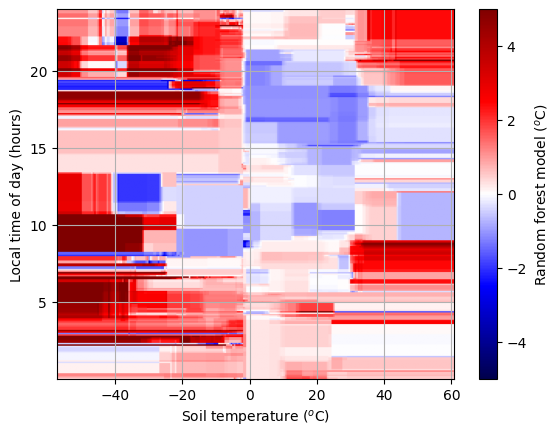

In [14]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Plot the model, only over the points where there is data in the test set.
plt.imshow((model_buffer)*(count>0), vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Random forest model ($^o$C)')

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Random forest model ($^o$C)')

plt.show()

The model constructed with random forests has a complex and blocky shape. These sharp edges denote where one or more tree has a branch point.
However it still produces unlikely results outside of the training dataset (for example the cold soil predictions in the early hours of the morning in the bottom plot).

How would you improve this model? Try adjusting some of the hyperparameters of the random forest model. What else could we do?